# Find distributions for each column for a specific zone

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [2]:
df_order = pd.read_csv("./IMA_recommendation_simulation_data.csv")

In [5]:
# import zip codes for origin and destination
def zz(value):
    if value < 100:
        return 'Z0'
    elif value < 200:
        return 'Z1'
    elif value < 300:
        return 'Z2'
    elif value < 400:
        return 'Z3'
    elif value < 500:
        return 'Z4'
    elif value < 600:
        return 'Z5'
    elif value < 700:
        return 'Z6'
    elif value < 800:
        return 'Z7'
    elif value < 900:
        return 'Z8'
    elif value < 1000:
        return 'Z9'
    else:
        return 'Error'


df_order['ZipZone_origin'] = df_order.apply(lambda column: zz(column['origin_dat_ref']),axis=1)
df_order['ZipZone_dest'] = df_order.apply(lambda column: zz(column['dest_dat_ref']),axis=1)



In [6]:
df_order.head()

,Unnamed: 0,request_id,week_id,weekday,miles,order_equipment_type,order_distance,order_num_stops,order_origin_weight,lead_days,color,origin_dat_ref,dest_dat_ref,rate_norm,est_cost_norm,CurrentCondition,ZipZone_origin,ZipZone_dest
0,0,c2653eda11cd4d94879d1946392eb2b5,4,Sat,1856,V,1848.0,2,40000.0,3,RED,633,978,2.273442,2.138631,Accepted,Z6,Z9
1,1,65e3dcc84a2246e68ea8636a967b31b2,3,Mon,56,V,47.0,2,12729.0,3,RED,604,604,-0.971030,-1.017024,Rejected,Z6,Z6
2,2,0a86f005640a4204b46c95ca033a7ced,1,Fri,259,V,255.0,2,44176.0,3,RED,761,770,-0.393352,-0.475805,Accepted,Z7,Z7
3,3,1105b4bc7b444f7985d4ad810e7acbc2,3,Thu,71,V,68.0,2,39847.0,6,RED,187,180,-0.706546,-0.765855,Rejected,Z1,Z1
4,4,de538100bb0f4137961b9551640ef35e,3,Fri,1182,R,1183.0,2,34912.0,3,GREEN,972,922,1.014233,0.469273,Accepted,Z9,Z9


In [9]:
# count 
region_interact = df_order.groupby(by = ['ZipZone_origin','ZipZone_dest'])
region_counts = region_interact.size().reset_index(name='counts')
#region_counts.tail()
region_counts.sort_values(by=['counts'])

,ZipZone_origin,ZipZone_dest,counts
8,Z0,Z8,40
80,Z8,Z0,47
82,Z8,Z2,79
90,Z9,Z0,97
5,Z0,Z5,113
...,...,...,...
22,Z2,Z2,3836
44,Z4,Z4,7849
77,Z7,Z7,11040
99,Z9,Z9,11753


In [16]:
# make a copy of the data for Z3 to Z3
df_order_Z33 = df_order.copy()
df_order_Z33 = df_order[(df_order['ZipZone_origin'] == 'Z3') & (df_order['ZipZone_dest'] == 'Z3')] #
df_order_Z33.head()

,Unnamed: 0,request_id,week_id,weekday,miles,order_equipment_type,order_distance,order_num_stops,order_origin_weight,lead_days,color,origin_dat_ref,dest_dat_ref,rate_norm,est_cost_norm,CurrentCondition,ZipZone_origin,ZipZone_dest
8,8,8f67eb6f89ff40bcb4289f1f62227df6,1,Wed,154,V,141.0,2,45679.0,6,YELLOW,326,347,-0.154330,-1.282368,Accepted,Z3,Z3
14,14,da4ec185b5644deea572fa379b9feed4,2,Wed,214,V,221.0,2,25677.0,7,GREEN,350,325,-0.099179,-0.129520,Accepted,Z3,Z3
17,17,f8a5bbfacc1b4e188fa7616da6c4207f,1,Wed,216,V,220.0,2,40349.0,8,RED,338,331,-0.869951,-0.933859,Rejected,Z3,Z3
21,21,9aac0768ac584c6d9459cf23dab7369a,1,Mon,57,V,60.0,2,39847.0,3,RED,328,338,-0.684707,-0.931124,Withdrawn,Z3,Z3
62,62,3278d00061f644a19c2c564da3888bcc,4,Wed,283,V,262.0,2,39478.0,2,RED,301,388,-1.285638,-1.147469,Rejected,Z3,Z3


In [17]:
df_order_Z33.shape

(13847, 18)

## Fit distributions for columns in the data Z3 to Z3

In [18]:
# fit distribution
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

### Continuous variables

In [19]:
# store names and sse for the testing distributions by rows in the code
best_fit_dist_names = []
best_sse_all = []

In [24]:
# Create models from data
def best_fit_distribution(df_order_Z33, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(df_order_Z33, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [#st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
                     #st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
                     #st.foldcauchy,st.foldnorm,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
                     #st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
                     #st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
                     #st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,
                     #st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable, #?
                     #st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf, #?
                     #st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
                     #st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
                     #st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
                     st.burr, st.genexpon
                    ]
     
    #    If computer taking too long, try running like ten distributions at a time             
    #    Can't run: st.ncf, st.ncx2, st.levy_stable
    
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params, best_sse)

In [25]:
def make_pdf(dist, params, size=10000): # size = 10000
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [26]:
# Find best fit distribution
best_fit_name, best_fit_params, best_sse = best_fit_distribution(df_order_Z33['miles'], 200, ax=None) # change to column you want
best_dist = getattr(st, best_fit_name)

print("Current best fit distribution: ", best_fit_name)
print("Current best fit sse: ", best_sse)

best_fit_dist_names.append(best_fit_name)
best_sse_all.append(best_sse)
print("Best fit distributions' names: ", best_fit_dist_names)
print("Best fit sse array: ", best_sse_all)

Current best fit distribution:  norm
Current best fit sse:  inf
Best fit distributions' names:  ['norm']
Best fit sse array:  [inf]


(267.38022676392, 196.42023685590306)
KstestResult(statistic=0.11656455756250417, pvalue=2.257130496112998e-164)
(0.004828504392059312, 0.009755096788475252, 0.973615397646594, 0.9999906076997483, 3.8464515239313446)
KstestResult(statistic=0.13669905226907925, pvalue=3.727915557397437e-226)


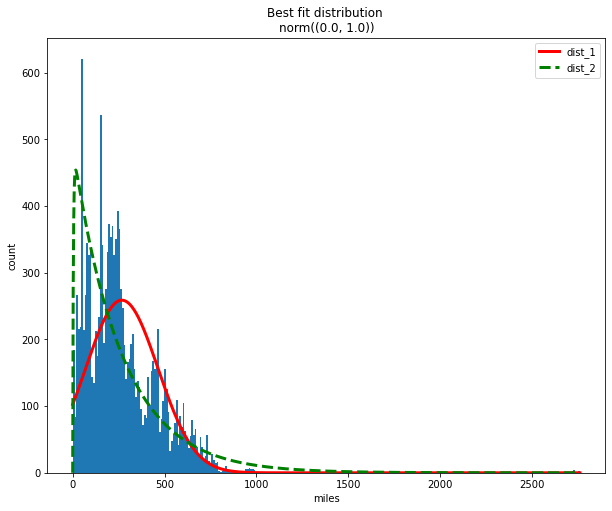

In [33]:
# plot 2 best fit distributions
import scipy.stats as st
import statsmodels.datasets

# Code to plot multiple distributions
max = df_order_Z33['miles'].max()
domain = np.linspace(0., max, 1000)

# 1
dist = st.norm # I guess here changing it to the best fit dist got above
args = dist.fit(df_order_Z33['miles'].dropna())
print(args)
print(st.kstest(df_order_Z33['miles'].dropna(),dist.cdf, args))
dist_1 = dist.pdf(domain, *args)

# 2
dist = st.genexpon
args = dist.fit(df_order_Z33['miles'].dropna())
print(args)
print(st.kstest(df_order_Z33['miles'].dropna(),dist.cdf, args))
dist_2 = dist.pdf(domain, *args)


nbins = 300
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.hist(df_order_Z33['miles'], nbins)
#ax.plot(data, 'miles', "-b", lw=3, label='dist')
ax.plot(domain, dist_1 * len(df_order_Z33['miles'].dropna()) * max / nbins,
        '-r', lw=3, label='dist_1')
ax.plot(domain, dist_2 * len(df_order_Z33['miles'].dropna()) * max / nbins,
        '--g', lw=3, label='dist_2')

dist_str = '{}({})'.format(best_fit_name, best_fit_params)
ax.set_title(u'Best fit distribution \n' + dist_str)
ax.set_xlabel("miles")
ax.set_ylabel("count")
ax.legend()



<AxesSubplot:xlabel='miles', ylabel='Density'>

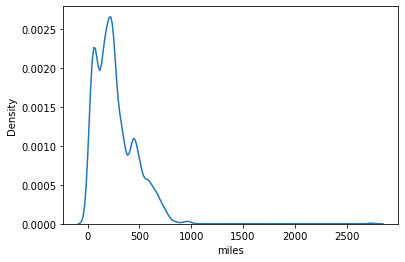

In [28]:
sns.kdeplot(df_order_Z33['miles'])

<AxesSubplot:xlabel='miles', ylabel='Count'>

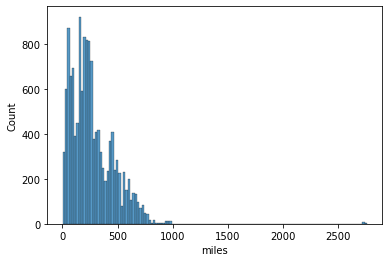

In [34]:
sns.histplot(df_order_Z33['miles'])